# Representation with a Feature Cross

In this exercise, you'll experiment with different ways to represent features.

## Learning Objectives:

After doing this Colab, you'll know how to:

  * Use [`tf.feature_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column) methods to represent features in different ways.
  * Represent features as [bins](https://developers.google.com/machine-learning/glossary/#bucketing). 
  * Cross bins to create a [feature cross](https://developers.google.com/machine-learning/glossary/#feature_cross). 

## The Dataset
  
Like several of the previous Colabs, this exercise uses the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description).

## Call the import statements

The following code imports the necessary code to run the code in the rest of this Colaboratory.

In [1]:
#@title Load the imports

import numpy as np
import pandas as pd
# import tensorflow as tf
# from tensorflow import feature_column
# from tensorflow.keras import layers

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import math
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# tf.keras.backend.set_floatx('float32')

print("Imported the modules.")

Imported the modules.


## Load, scale, and shuffle the examples

The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set
* `test_df`, which contains the test set

The code cell then scales the `median_house_value` to a more human-friendly range and then shuffles the examples.

In [2]:
# Load the dataset
orign_train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Scale the labels
scale_factor = 1000.0
# Scale the training set's label.
orign_train_df["median_house_value"] /= scale_factor 

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

# Shuffle the examples
orign_train_df = orign_train_df.reindex(np.random.permutation(orign_train_df.index))

In [3]:
orign_train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
8838,-118.7,34.3,23.0,1983.0,280.0,978.0,287.0,6.3,236.7
1030,-117.1,32.7,29.0,4174.0,1195.0,3675.0,1124.0,1.8,103.6
673,-117.0,32.6,26.0,2074.0,356.0,1228.0,335.0,4.1,160.2
15358,-122.3,37.9,52.0,895.0,198.0,386.0,204.0,3.9,182.6
8929,-118.9,34.2,32.0,2399.0,384.0,1199.0,390.0,4.1,264.6


In [4]:
test_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.0,37.4,27.0,3885.0,661.0,1537.0,606.0,6.6,344.7
1,-118.3,34.3,43.0,1510.0,310.0,809.0,277.0,3.6,176.5
2,-117.8,33.8,27.0,3589.0,507.0,1484.0,495.0,5.8,270.5
3,-118.4,33.8,28.0,67.0,15.0,49.0,11.0,6.1,330.0
4,-119.7,36.3,19.0,1241.0,244.0,850.0,237.0,2.9,81.7


## Represent latitude and longitude as floating-point values

Previous Colabs trained on only a single feature or a single synthetic feature. By contrast, this exercise trains on two features. Furthermore, this Colab introduces **feature columns**, which provide a sophisticated way to represent features.  

You create feature columns as possible:

  * Call a [`tf.feature_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column) method to represent a single feature, single feature cross, or single synthetic feature in the desired way.  For example, to represent a certain feature as floating-point values, call [`tf.feature_column.numeric_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column). To represent a certain feature as a series of buckets or bins, call [`tf.feature_column.bucketized_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column).
  * Assemble the created representations into a Python list. 

A neighborhood's location is typically the most important feature in determining a house's value. The California Housing dataset provides two features, `latitude` and `longitude` that identify each neighborhood's location. 

The following code cell calls [`tf.feature_column.numeric_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/numeric_column) twice, first to represent `latitude` as floating-point value and a second time to represent `longitude` as floating-point values. 

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in `fp_feature_layer`) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model. 


In [5]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = [f for f in list(orign_train_df.columns) if f != "median_house_value"]

print(feature_columns)

# X_train = orign_train_df[feature_columns] 
# Y_train = orign_train_df[["median_house_value"]]

# X_train.head()

DenseFeatures = ["latitude", "longitude"]

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


In [6]:
train_df, valid_df = train_test_split(orign_train_df, test_size=0.2)

In [7]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
10887,-120.8,37.5,8.0,1191.0,242.0,688.0,260.0,2.7,138.4
10355,-120.1,36.9,32.0,2089.0,468.0,1765.0,427.0,2.2,61.7
1519,-117.2,33.6,7.0,7722.0,1324.0,2975.0,1161.0,3.6,150.9
8258,-118.5,34.3,9.0,1739.0,358.0,820.0,323.0,4.1,182.5
9918,-119.7,34.4,27.0,1448.0,404.0,978.0,338.0,2.3,261.0


In [8]:
def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:, specified_column] ,0).reshape(1, -1)
        X_std  = np.std(X[:, specified_column], 0).reshape(1, -1)

    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
     
    return X, X_mean, X_std

_, X_mean, X_std = _normalize(train_df.to_numpy(dtype=float), train = True, specified_column=[0, 1]) # create mean, var from train set
print("X_mean: ", X_mean)
print("X_std: ", X_std)

X_mean:  [[-119.56449485   35.62573015]]
X_std:  [[2.00776444 2.1329513 ]]


In [9]:
from sklearn.model_selection import train_test_split

tfm = transforms.Compose([
    transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
])

class MyDataset(Dataset):
 
    def __init__(self, df, tfm, specified_column, X_mean, X_std):
       
        self.transform = tfm
        x=df[feature_columns].values
        y=df[["median_house_value"]].values

        self.x_train=torch.tensor(x,dtype=torch.float32)
        self.y_train=torch.tensor(y,dtype=torch.float32)
    
        for col in specified_column:
            # print("X_mean: ", X_mean[0, col])
            # print("X_std: ", X_std[0, col])
            # print("self.x_train: ", self.x_train[:,col])
            self.x_train[:,col] = (self.x_train[:, col] - X_mean[0, col]) / (X_std[0, col] + 1e-8)
            # print("self.x_train: ", self.x_train[:,col])
            # print("-------------------------")                  

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

train_ds = MyDataset(train_df, tfm, [0, 1], X_mean, X_std)
valid_ds = MyDataset(valid_df, tfm, [0, 1], X_mean, X_std)
test_ds = MyDataset(test_df, tfm,  [0, 1], X_mean, X_std)

train_loader=DataLoader(train_ds,batch_size=10,shuffle=False)

valid_loader=DataLoader(valid_ds,batch_size=10,shuffle=False)

test_loader=DataLoader(test_ds,batch_size=10,shuffle=False)

## Define functions that create and train a model, and a plotting function

The following code defines three functions:

  * `create_model`, which tells TensorFlow to build a linear regression model and to use the `feature_layer_as_fp` as the representation of the model's features.
  * `train_model`, which will ultimately train the model from training set examples.
  * `plot_the_loss_curve`, which generates a loss curve.

In [10]:
learning_rate = 0.04
n_epochs = 35
batch_size = 100
validation_split = 0.2  

In [11]:
from torch import nn

class Sequential(nn.Module):
    def __init__(self):
        super(Sequential, self).__init__()
        self.hid = nn.Sequential(
                    nn.Linear(8, 1),
                )
    def forward(self, x):
        out = self.hid(x)
        return out
    
Sequential()

Sequential(
  (hid): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [12]:
model = Sequential()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.1, eps=1e-08, 
#                                 weight_decay=0.1, momentum=0.2, centered=False)
loss_func = nn.MSELoss()   
    
    
epoch_train_loss = []

epoch_valid_loss = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(math.sqrt(train_loss))
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):
        X, y = batch   
       
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append(math.sqrt(valid_loss))
        
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} root_mean_squared_error = {math.sqrt(train_loss):.5f}  | \
          valid_loss = {valid_loss:.5f} val_root_mean_squared_error = {math.sqrt(valid_loss):.5f}")

print("Defined the build_model and train_model functions.")


[ Epoch | 001/035 ]           train_loss = 36050.47983 root_mean_squared_error = 189.86964  |           valid_loss = 165234.06960 val_root_mean_squared_error = 406.48994



[ Epoch | 002/035 ]           train_loss = 31167.86269 root_mean_squared_error = 176.54422  |           valid_loss = 189853.26108 val_root_mean_squared_error = 435.72154



[ Epoch | 003/035 ]           train_loss = 30152.92409 root_mean_squared_error = 173.64597  |           valid_loss = 165215.39498 val_root_mean_squared_error = 406.46697



[ Epoch | 004/035 ]           train_loss = 29431.09544 root_mean_squared_error = 171.55493  |           valid_loss = 141168.44141 val_root_mean_squared_error = 375.72389



[ Epoch | 005/035 ]           train_loss = 28926.47511 root_mean_squared_error = 170.07785  |           valid_loss = 118983.65460 val_root_mean_squared_error = 344.94007



[ Epoch | 006/035 ]           train_loss = 28587.69736 root_mean_squared_error = 169.07897  |           valid_loss = 101606.43819 val_root_mean_squared_error = 318.75765



[ Epoch | 007/035 ]           train_loss = 28375.81478 root_mean_squared_error = 168.45122  |           valid_loss = 88870.04649 val_root_mean_squared_error = 298.11080



[ Epoch | 008/035 ]           train_loss = 28261.46878 root_mean_squared_error = 168.11148  |           valid_loss = 78512.85782 val_root_mean_squared_error = 280.20146



[ Epoch | 009/035 ]           train_loss = 28224.49567 root_mean_squared_error = 168.00148  |           valid_loss = 70746.25674 val_root_mean_squared_error = 265.98168



[ Epoch | 010/035 ]           train_loss = 28244.55976 root_mean_squared_error = 168.06118  |           valid_loss = 64892.32542 val_root_mean_squared_error = 254.73972



[ Epoch | 011/035 ]           train_loss = 28475.09306 root_mean_squared_error = 168.74565  |           valid_loss = 59090.90041 val_root_mean_squared_error = 243.08620



[ Epoch | 012/035 ]           train_loss = 28684.64695 root_mean_squared_error = 169.36542  |           valid_loss = 54220.91027 val_root_mean_squared_error = 232.85384



[ Epoch | 013/035 ]           train_loss = 28764.21911 root_mean_squared_error = 169.60017  |           valid_loss = 50477.51188 val_root_mean_squared_error = 224.67201



[ Epoch | 014/035 ]           train_loss = 28776.27645 root_mean_squared_error = 169.63572  |           valid_loss = 47628.22238 val_root_mean_squared_error = 218.23891



[ Epoch | 015/035 ]           train_loss = 28756.23140 root_mean_squared_error = 169.57662  |           valid_loss = 45455.59423 val_root_mean_squared_error = 213.20318



[ Epoch | 016/035 ]           train_loss = 28718.16043 root_mean_squared_error = 169.46433  |           valid_loss = 43792.21379 val_root_mean_squared_error = 209.26589



[ Epoch | 017/035 ]           train_loss = 28671.36617 root_mean_squared_error = 169.32621  |           valid_loss = 42509.80664 val_root_mean_squared_error = 206.17906



[ Epoch | 018/035 ]           train_loss = 28623.17814 root_mean_squared_error = 169.18386  |           valid_loss = 41514.12026 val_root_mean_squared_error = 203.75014



[ Epoch | 019/035 ]           train_loss = 28578.31659 root_mean_squared_error = 169.05122  |           valid_loss = 40734.12457 val_root_mean_squared_error = 201.82697



[ Epoch | 020/035 ]           train_loss = 28539.08278 root_mean_squared_error = 168.93514  |           valid_loss = 40117.36666 val_root_mean_squared_error = 200.29320



[ Epoch | 021/035 ]           train_loss = 28506.00571 root_mean_squared_error = 168.83722  |           valid_loss = 39623.48931 val_root_mean_squared_error = 199.05650



[ Epoch | 022/035 ]           train_loss = 28478.67736 root_mean_squared_error = 168.75627  |           valid_loss = 39221.20289 val_root_mean_squared_error = 198.04344



[ Epoch | 023/035 ]           train_loss = 28456.30889 root_mean_squared_error = 168.68998  |           valid_loss = 38885.31427 val_root_mean_squared_error = 197.19360



[ Epoch | 024/035 ]           train_loss = 28437.90575 root_mean_squared_error = 168.63542  |           valid_loss = 38601.96238 val_root_mean_squared_error = 196.47382



[ Epoch | 025/035 ]           train_loss = 28422.83053 root_mean_squared_error = 168.59072  |           valid_loss = 38356.67096 val_root_mean_squared_error = 195.84859



[ Epoch | 026/035 ]           train_loss = 28410.37204 root_mean_squared_error = 168.55377  |           valid_loss = 38139.37870 val_root_mean_squared_error = 195.29306



[ Epoch | 027/035 ]           train_loss = 28399.86032 root_mean_squared_error = 168.52258  |           valid_loss = 37944.06914 val_root_mean_squared_error = 194.79237



[ Epoch | 028/035 ]           train_loss = 28390.95373 root_mean_squared_error = 168.49615  |           valid_loss = 37764.17758 val_root_mean_squared_error = 194.33007



[ Epoch | 029/035 ]           train_loss = 28383.15574 root_mean_squared_error = 168.47301  |           valid_loss = 37596.52780 val_root_mean_squared_error = 193.89824



[ Epoch | 030/035 ]           train_loss = 28376.25694 root_mean_squared_error = 168.45254  |           valid_loss = 37438.96703 val_root_mean_squared_error = 193.49152



[ Epoch | 031/035 ]           train_loss = 28370.15506 root_mean_squared_error = 168.43442  |           valid_loss = 37288.15730 val_root_mean_squared_error = 193.10142



[ Epoch | 032/035 ]           train_loss = 28364.52747 root_mean_squared_error = 168.41772  |           valid_loss = 37142.08357 val_root_mean_squared_error = 192.72282



[ Epoch | 033/035 ]           train_loss = 28359.23007 root_mean_squared_error = 168.40199  |           valid_loss = 36999.98684 val_root_mean_squared_error = 192.35381



[ Epoch | 034/035 ]           train_loss = 28354.23626 root_mean_squared_error = 168.38716  |           valid_loss = 36861.74698 val_root_mean_squared_error = 191.99413



[ Epoch | 035/035 ]           train_loss = 28349.55343 root_mean_squared_error = 168.37326  |           valid_loss = 36725.78633 val_root_mean_squared_error = 191.63973
Defined the build_model and train_model functions.


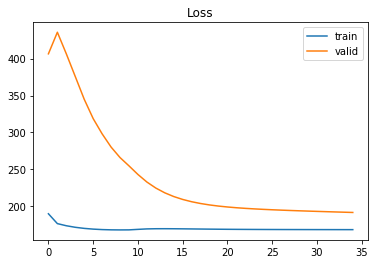

In [13]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_train_loss)
plt.plot(epoch_valid_loss)
plt.title('Loss')
plt.legend(['train', 'valid'])
plt.savefig('loss.png')
plt.show()

In [14]:
# These are used to record information in validation.
test_loss = []

# Iterate the validation set by batches.
for batch in tqdm(test_loader):
    X, y = batch   
   
    y_hat = model(X)
    loss = loss_func(y_hat, y) #rmse

    # Record the loss and accuracy.
    test_loss.append(loss.item())

 # The average loss and accuracy for entire validation set is the average of the recorded values.
test_loss = sum(test_loss) / len(test_loss)

# Print the information.
print(f"test_loss = {test_loss:.5f} root_mean_squared_error = {math.sqrt(test_loss):.5f}")


test_loss = 33540.12918 root_mean_squared_error = 183.13964


## Represent latitude and longitude in buckets

The following code cell represents latitude and longitude in buckets (bins). Each bin represents all the neighborhoods within a single degree. For example,
neighborhoods at latitude 35.4 and 35.8 are in the same bucket, but neighborhoods in latitude 35.4 and 36.2 are in different buckets. 

The model will learn a separate weight for each bucket. For example, the model will learn one weight for all the neighborhoods in the "35" bin, a different weight for neighborhoods in the "36" bin, and so on. This representation will create approximately 20 buckets:
 
  * 10 buckets for `latitude`. 
  * 10 buckets for `longitude`. 

In [15]:
resolution_in_degrees = 1.0 

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for latitude.
# latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), 
                                     int(max(train_df['latitude'])), 
                                     resolution_in_degrees))

print("latitude_boundaries: ", latitude_boundaries)
# latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, 
#                                                latitude_boundaries)
feature_columns.append("latitude")

# Create a bucket feature column for longitude.
# longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), 
                                      int(max(train_df['longitude'])), 
                                      resolution_in_degrees))
print("longitude_boundaries: ", longitude_boundaries)
# longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
#                                                 longitude_boundaries)
feature_columns.append("longitude")

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
# buckets_feature_layer = layers.DenseFeatures(feature_columns)

latitude_boundaries:  [-1.0, 0.0, 1.0]
longitude_boundaries:  [-2.0, -1.0, 0.0, 1.0]


In [16]:
def latitude_app(val):
    if val < -1.0: return 0
    elif val < 0.0: return 1
    elif val < 1.0: return 2
    else: return 3

def longitude_app(val):
    if val < -2.0: return 0
    elif val < -1.0: return 1
    elif val < 0.0: return 2
    elif val < 1.0: return 3
    else: return 4   

train_df['latitude'] = train_df.apply(lambda r: latitude_app(r['latitude']), axis=1)
train_df['longitude'] = train_df.apply(lambda r: longitude_app(r['longitude']), axis=1)   

train_df.head()

/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
10887,2,2,8.0,1191.0,242.0,688.0,260.0,2.7,138.4
10355,2,2,32.0,2089.0,468.0,1765.0,427.0,2.2,61.7
1519,4,1,7.0,7722.0,1324.0,2975.0,1161.0,3.6,150.9
8258,3,1,9.0,1739.0,358.0,820.0,323.0,4.1,182.5
9918,2,1,27.0,1448.0,404.0,978.0,338.0,2.3,261.0


In [17]:
model = Sequential()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.1, eps=1e-08, 
#                                 weight_decay=0.1, momentum=0.2, centered=False)
loss_func = nn.MSELoss()   
    
    
epoch_train_loss = []

epoch_valid_loss = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    # for batch in tqdm(trainloader):
    for batch in tqdm(train_loader):
        X, y = batch          
        # print(X)
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(math.sqrt(train_loss))
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):
        X, y = batch   
       
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append(math.sqrt(valid_loss))
        
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} root_mean_squared_error = {math.sqrt(train_loss):.5f}  | \
          valid_loss = {valid_loss:.5f} val_root_mean_squared_error = {math.sqrt(valid_loss):.5f}")

print("Defined the build_model and train_model functions.")


[ Epoch | 001/035 ]           train_loss = 35772.99870 root_mean_squared_error = 189.13751  |           valid_loss = 141486.72763 val_root_mean_squared_error = 376.14722



[ Epoch | 002/035 ]           train_loss = 31624.69387 root_mean_squared_error = 177.83333  |           valid_loss = 145635.66849 val_root_mean_squared_error = 381.62242



[ Epoch | 003/035 ]           train_loss = 30361.77903 root_mean_squared_error = 174.24632  |           valid_loss = 145501.85348 val_root_mean_squared_error = 381.44705



[ Epoch | 004/035 ]           train_loss = 29534.08377 root_mean_squared_error = 171.85483  |           valid_loss = 135707.53909 val_root_mean_squared_error = 368.38504



[ Epoch | 005/035 ]           train_loss = 28986.42222 root_mean_squared_error = 170.25399  |           valid_loss = 118615.74949 val_root_mean_squared_error = 344.40637



[ Epoch | 006/035 ]           train_loss = 28624.04222 root_mean_squared_error = 169.18641  |           valid_loss = 102263.90424 val_root_mean_squared_error = 319.78728



[ Epoch | 007/035 ]           train_loss = 28396.58623 root_mean_squared_error = 168.51287  |           valid_loss = 89695.01648 val_root_mean_squared_error = 299.49126



[ Epoch | 008/035 ]           train_loss = 28269.81365 root_mean_squared_error = 168.13629  |           valid_loss = 79285.14469 val_root_mean_squared_error = 281.57618



[ Epoch | 009/035 ]           train_loss = 28227.42824 root_mean_squared_error = 168.01020  |           valid_loss = 71190.34625 val_root_mean_squared_error = 266.81519



[ Epoch | 010/035 ]           train_loss = 28232.84760 root_mean_squared_error = 168.02633  |           valid_loss = 65289.08582 val_root_mean_squared_error = 255.51729



[ Epoch | 011/035 ]           train_loss = 28441.67858 root_mean_squared_error = 168.64661  |           valid_loss = 59451.55532 val_root_mean_squared_error = 243.82690



[ Epoch | 012/035 ]           train_loss = 28668.11222 root_mean_squared_error = 169.31660  |           valid_loss = 54440.62121 val_root_mean_squared_error = 233.32514



[ Epoch | 013/035 ]           train_loss = 28759.69786 root_mean_squared_error = 169.58684  |           valid_loss = 50575.66192 val_root_mean_squared_error = 224.89033



[ Epoch | 014/035 ]           train_loss = 28776.86810 root_mean_squared_error = 169.63746  |           valid_loss = 47634.56148 val_root_mean_squared_error = 218.25343



[ Epoch | 015/035 ]           train_loss = 28759.35144 root_mean_squared_error = 169.58582  |           valid_loss = 45394.76105 val_root_mean_squared_error = 213.06046



[ Epoch | 016/035 ]           train_loss = 28722.46417 root_mean_squared_error = 169.47703  |           valid_loss = 43680.48526 val_root_mean_squared_error = 208.99877



[ Epoch | 017/035 ]           train_loss = 28675.76476 root_mean_squared_error = 169.33920  |           valid_loss = 42361.04134 val_root_mean_squared_error = 205.81798



[ Epoch | 018/035 ]           train_loss = 28626.89466 root_mean_squared_error = 169.19484  |           valid_loss = 41337.72978 val_root_mean_squared_error = 203.31682



[ Epoch | 019/035 ]           train_loss = 28581.04749 root_mean_squared_error = 169.05930  |           valid_loss = 40538.08440 val_root_mean_squared_error = 201.34072



[ Epoch | 020/035 ]           train_loss = 28540.74182 root_mean_squared_error = 168.94005  |           valid_loss = 39907.28842 val_root_mean_squared_error = 199.76809



[ Epoch | 021/035 ]           train_loss = 28506.72233 root_mean_squared_error = 168.83934  |           valid_loss = 39400.90146 val_root_mean_squared_error = 198.49660



[ Epoch | 022/035 ]           train_loss = 28478.43353 root_mean_squared_error = 168.75554  |           valid_loss = 38989.43396 val_root_mean_squared_error = 197.45742



[ Epoch | 023/035 ]           train_loss = 28455.25206 root_mean_squared_error = 168.68685  |           valid_loss = 38648.76194 val_root_mean_squared_error = 196.59288



[ Epoch | 024/035 ]           train_loss = 28436.32939 root_mean_squared_error = 168.63075  |           valid_loss = 38361.70502 val_root_mean_squared_error = 195.86144



[ Epoch | 025/035 ]           train_loss = 28420.87135 root_mean_squared_error = 168.58491  |           valid_loss = 38112.81360 val_root_mean_squared_error = 195.22503



[ Epoch | 026/035 ]           train_loss = 28407.94148 root_mean_squared_error = 168.54656  |           valid_loss = 37893.21547 val_root_mean_squared_error = 194.66180



[ Epoch | 027/035 ]           train_loss = 28397.17401 root_mean_squared_error = 168.51461  |           valid_loss = 37696.70082 val_root_mean_squared_error = 194.15638



[ Epoch | 028/035 ]           train_loss = 28388.01834 root_mean_squared_error = 168.48744  |           valid_loss = 37516.92318 val_root_mean_squared_error = 193.69286



[ Epoch | 029/035 ]           train_loss = 28380.12352 root_mean_squared_error = 168.46401  |           valid_loss = 37349.12992 val_root_mean_squared_error = 193.25923



[ Epoch | 030/035 ]           train_loss = 28373.15027 root_mean_squared_error = 168.44331  |           valid_loss = 37190.31340 val_root_mean_squared_error = 192.84790



[ Epoch | 031/035 ]           train_loss = 28366.83475 root_mean_squared_error = 168.42457  |           valid_loss = 37039.51889 val_root_mean_squared_error = 192.45654



[ Epoch | 032/035 ]           train_loss = 28361.11589 root_mean_squared_error = 168.40759  |           valid_loss = 36893.22126 val_root_mean_squared_error = 192.07608



[ Epoch | 033/035 ]           train_loss = 28355.74092 root_mean_squared_error = 168.39163  |           valid_loss = 36752.53628 val_root_mean_squared_error = 191.70951



[ Epoch | 034/035 ]           train_loss = 28350.76861 root_mean_squared_error = 168.37686  |           valid_loss = 36614.51515 val_root_mean_squared_error = 191.34920



[ Epoch | 035/035 ]           train_loss = 28346.01965 root_mean_squared_error = 168.36276  |           valid_loss = 36479.74891 val_root_mean_squared_error = 190.99672
Defined the build_model and train_model functions.


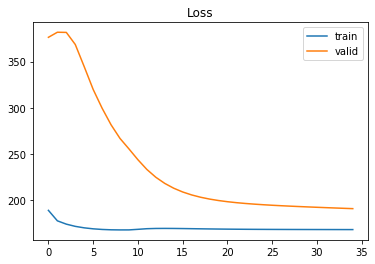

In [18]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_train_loss)
plt.plot(epoch_valid_loss)
plt.title('Loss')
plt.legend(['train', 'valid'])
plt.savefig('loss.png')
plt.show()

In [19]:
# These are used to record information in validation.
test_loss = []

# Iterate the validation set by batches.
for batch in tqdm(test_loader):
    X, y = batch   
   
    y_hat = model(X)
    loss = loss_func(y_hat, y) #rmse

    # Record the loss and accuracy.
    test_loss.append(loss.item())

 # The average loss and accuracy for entire validation set is the average of the recorded values.
test_loss = sum(test_loss) / len(test_loss)

# Print the information.
print(f"test_loss = {test_loss:.5f} root_mean_squared_error = {math.sqrt(test_loss):.5f}")


test_loss = 33306.23806 root_mean_squared_error = 182.49997
